Perform [box method](https://doi.org/10.1029/2007JF000927) by terminating [curvilinear boxes](https://doi.org/10.3189/2014JoG13J061) with terminus traces and write resulting geometry to disk

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import LineString, Point
from shapely.ops import split

# Flag to enable descriptive plots of box method
PLOT = False

# Read terminus boxes and traces
boxes = gpd.read_file("../data/terminus/terminus_boxes.geojson")
traces = gpd.read_file("../data/terminus/terminus_traces_2000_2023.geojson")

# To store trace-terminated boxes before combined
boxes_gdf = []

# Perform box method
for glacier, traces_glacier in traces.groupby(by="glacier"):
    # Collect curvilinear box for current glacier
    box_glacier = boxes.loc[boxes.glacier == glacier].reset_index()

    # Remove traces with quality flag of '1' and sort by date
    traces_glacier = traces_glacier.loc[traces_glacier.quality != "1"]
    traces_glacier = traces_glacier.sort_values(by="date", ascending=False)

    for _, trace in traces_glacier.iterrows():
        # Attempt to split box by terminus trace
        difference = split(box_glacier.geometry.item(), trace.geometry.geoms[0])

        # Relocate distances are null if box was split successfully
        start_relocate_distance = 0
        end_relocate_distance = 0

        # If split was unsuccessful then extend trace to fully intersect box
        if len(difference.geoms) == 1:
            # Alias necessary geometry
            box_poly = box_glacier.geometry.item().geoms[0]
            box_edge = box_poly.exterior
            trace_line = trace.geometry.geoms[0]
            trace_start_coords = trace_line.coords[0]
            trace_end_coords = trace_line.coords[-1]
            trace_start_point = Point(trace_start_coords)
            trace_end_point = Point(trace_end_coords)

            # Copy of trace where relocated start/end coords will be inserted
            trace_line_extended = list(trace_line.coords)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_start_point):
                start_interp = box_edge.interpolate(box_edge.project(trace_start_point))
                shifted = box_edge.interpolate(box_edge.project(start_interp) - 10)
                vector = np.array(start_interp.coords[0]) - np.array(shifted.coords[0])
                start_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                start_interp_extended = (
                    start_interp.x - start_interp_extended[0] * 50,
                    start_interp.y - start_interp_extended[1] * 50,
                )
                trace_line_extended[0] = start_interp_extended
                start_relocate_distance = start_interp.distance(trace_start_point)

            # Trace start point falls within box, so we need to extend to edge
            if box_poly.contains(trace_end_point):
                end_interp = box_edge.interpolate(box_edge.project(trace_end_point))
                shifted = box_edge.interpolate(box_edge.project(end_interp) + 50)
                vector = np.array(end_interp.coords[0]) - np.array(shifted.coords[0])
                end_interp_extended = (vector[1], -vector[0]) / np.linalg.norm(vector)
                end_interp_extended = (
                    end_interp.x + end_interp_extended[0] * 50,
                    end_interp.y + end_interp_extended[1] * 50,
                )
                trace_line_extended[-1] = end_interp_extended
                end_relocate_distance = end_interp.distance(trace_end_point)

            # Reconstructs trace line with new start and/or end coords
            trace_line_extended = LineString(trace_line_extended)

            # Splits box by interpolated trace
            difference = split(box_glacier.geometry[0], trace_line_extended)

            # Optional plot to display original and modified trace, plus terminated box
            if PLOT:
                box_glacier.geometry.plot(color="grey", alpha=0.5, edgecolor="black")
                plt.fill(*difference.geoms[1].exterior.xy, linewidth=1, c="red", alpha=0.2)
                plt.plot(*trace_line_extended.xy, linewidth=1, c="blue")
                plt.plot(*trace_line.xy, linestyle="-", linewidth=1, c="orange")
                plt.plot(*trace_start_coords, marker="o", markersize=2, c="green")
                plt.plot(*trace_end_coords, marker="o", markersize=2, c="red")
                plt.show()

        # Assign attributes from trace to trace-terminated box
        box_gdf = trace.drop(labels="geometry")
        box_gdf["geometry"] = difference.geoms[1]
        box_gdf["area"] = difference.geoms[1].area
        box_gdf["area_width_averaged"] = difference.geoms[1].area / box_glacier.width[0]
        box_gdf["start_relocate_distance"] = start_relocate_distance
        box_gdf["end_relocate_distance"] = end_relocate_distance
        box_gdf = gpd.GeoDataFrame(box_gdf).transpose()
        box_gdf = box_gdf.set_geometry("geometry").set_crs(3413)
        boxes_gdf.append(box_gdf)

# Concat trace-terminated boxes into one GeoDataFrame, sort, and save geometry to disk
boxes_gdf = pd.concat(boxes_gdf, ignore_index=True)
boxes_gdf = boxes_gdf.sort_values(by=["glacier", "date"])
boxes_gdf.to_file("../data/terminus/terminus_boxes_2000_2023.geojson", driver="GeoJSON")
boxes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1267 entries, 913 to 914
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   date                     1267 non-null   object  
 1   image_id                 1257 non-null   object  
 2   satellite                1257 non-null   object  
 3   glacier                  1267 non-null   object  
 4   glacier_code             1267 non-null   object  
 5   quality                  1267 non-null   object  
 6   source                   1267 non-null   object  
 7   geometry                 1267 non-null   geometry
 8   area                     1267 non-null   object  
 9   area_width_averaged      1267 non-null   object  
 10  start_relocate_distance  1267 non-null   object  
 11  end_relocate_distance    1267 non-null   object  
dtypes: geometry(1), object(11)
memory usage: 128.7+ KB


In [ ]:
boxes_gdf["date"] = pd.to_datetime(boxes_gdf.date)
gdf = boxes_gdf[boxes_gdf.glacier == "UNNAMED_UUNARTIT_ISLANDS"]
median_per_year = gdf.groupby(gdf.date.dt.year).area_width_averaged.median().reset_index()
boxes_gdf[boxes_gdf.area_width_averaged.isin(median_per_year.area_width_averaged)].plot(alpha=0.2, edgecolor="red")

Convert to xarray.Dataset and calculate changes in terminus position relative to first observation

In [ ]:
# Metadata for final Dataset
GLOBAL_ATTRS = {
    "author": "King, O. G.",
    "projection": "3413",
    "title": "Terminus traces for Daugaard-Jensen and Unnamed Uunartit Islands glaciers, Greenland, 1985-2024",
    "version": "2024-06-27",
}
VAR_ATTRS = {
    "glacier": {
        "description": "Glacier name, as taken from the Mouginot and others (2019) Greenland basins dataset",
    },
    "time": {
        "description": "Datetime of image used for terminus trace",
    },
    "image_id": {
        "description": "ID of satellite image used for terminus trace",
    },
    "satellite": {
        "description": "Name of imaging satellite",
    },
    "quality": {
        "description": "Quality flag of terminus trace",
        "units": "0=no issues/not supplied; 1=estimated, uncertain, or affected by cloud cover; 4=Landsat 7 SCL-off",
    },
    "source": {
        "description": "Source of terminus trace",
        "citation": [
            "Black=Black & Joughin (2022) https://doi.org/10.5067/DGBOSSIULSTD",
            "Brough=Brough and others (2023) https://doi.org/10.5281/zenodo.6904218",
            "Joughin=Joughin and others (2021) https://doi.org/10.5067/ESFWE11AVFKW",
            "King=King (2024) This study",
            "TermPicks_<AUTHOR>=Goliber and others (2021) https://doi.org/10.5281/zenodo.6557981",
        ],
    },
    "geometry_wkt": {
        "description": "Geometry of trace-terminated box",
        "type": "Well Known Text (WKT)",
    },
    "area": {
        "description": "Box area",
        "units": "metres squared [m2]",
    },
    "area_width_averaged": {
        "description": "Box area normalised by glacier width",
        "units": "metres squared [m2]",
    },
    "start_relocate_distance": {
        "description": "Distance from original start node to interpolated start node on box edge",
        "units": "metres",
    },
    "end_relocate_distance": {
        "description": "Distance from original end node to interpolated end node on box edge",
        "units": "metres",
    },
    "area_width_averaged_change": {
        "description": "Change in width-averaged box area relative to the earliest observation",
        "units": "metres squared [m2]",
    },
}

# Convert geometry to WKT (because xarray disallows arbitrary Python objects when writing NetCDF)
boxes_gdf["geometry_wkt"] = [geom.wkt for geom in boxes_gdf.geometry.values]

# Convert GeoDataFrame to xarray.Dataset
terminus_ds = boxes_gdf.set_index(["glacier", "date"]).to_xarray()

# Assign types to each dim/coord/var
terminus_ds = terminus_ds.rename(date="time")
terminus_ds = terminus_ds.drop_vars(["geometry", "glacier_code"])
terminus_ds["time"] = pd.to_datetime(terminus_ds.time)
terminus_ds["area"] = terminus_ds.area.astype(float)
terminus_ds["area_width_averaged"] = terminus_ds.area_width_averaged.astype(float)
terminus_ds["end_relocate_distance"] = terminus_ds.end_relocate_distance.astype(float)
terminus_ds["start_relocate_distance"] = terminus_ds.start_relocate_distance.astype(float)
terminus_ds["geometry_wkt"] = terminus_ds.geometry_wkt.astype(str)
terminus_ds["glacier"] = terminus_ds.glacier.astype(str)
terminus_ds["image_id"] = terminus_ds.image_id.astype(str)
terminus_ds["quality"] = terminus_ds.quality.astype(str)
terminus_ds["satellite"] = terminus_ds.satellite.astype(str)
terminus_ds["source"] = terminus_ds.source.astype(str)

# Remove traces where either relocation distance exceeds 100 metres
mask = (terminus_ds.start_relocate_distance < 100) & (terminus_ds.end_relocate_distance < 100)
terminus_ds = terminus_ds.where(mask, drop=True)

# Calculate change in terminus position relative to first observation
terminus_area = terminus_ds.area_width_averaged.groupby("glacier")
terminus_baseline = terminus_ds.area_width_averaged.groupby("glacier").first().dropna("time").isel(time=0)
terminus_ds["area_width_averaged_change"] = terminus_area - terminus_baseline

# Assign metadata
terminus_ds = terminus_ds.assign_attrs(GLOBAL_ATTRS)
for key, val in VAR_ATTRS.items():
    terminus_ds[key] = terminus_ds[key].assign_attrs(val)

# Write final Dataset to disk
terminus_ds.to_netcdf("../data/terminus/terminus_2000_2023.nc")
terminus_ds

Quick visualisation of terminus change time series

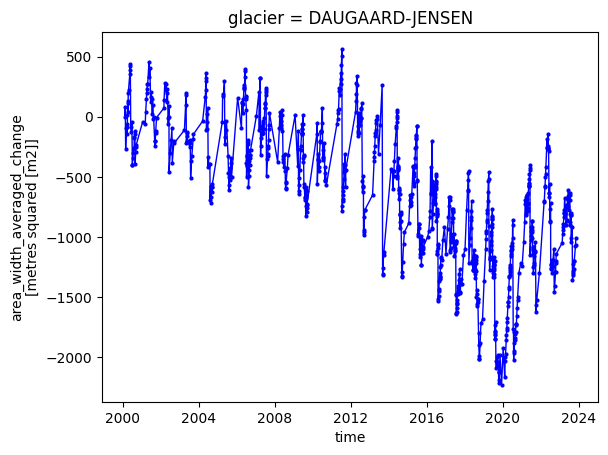

In [41]:
terminus_ds.area_width_averaged_change.sel(glacier="DAUGAARD-JENSEN").dropna("time").plot(
    c="blue", marker="o", markersize=2, linewidth=1
)

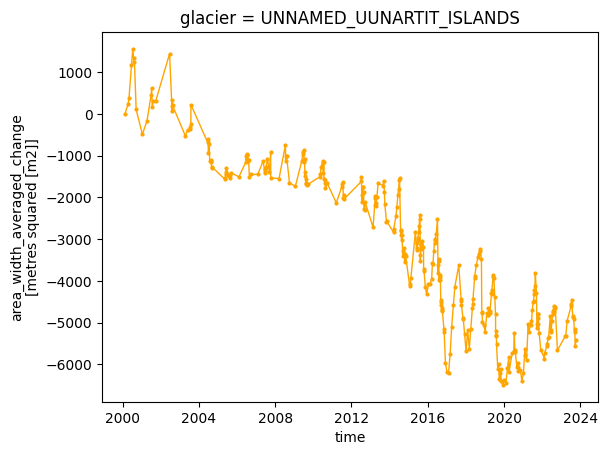

In [40]:
terminus_ds.area_width_averaged_change.sel(glacier="UNNAMED_UUNARTIT_ISLANDS").dropna("time").plot(
    c="orange", marker="o", markersize=2, linewidth=1
)

Linear regression of terminus change against time

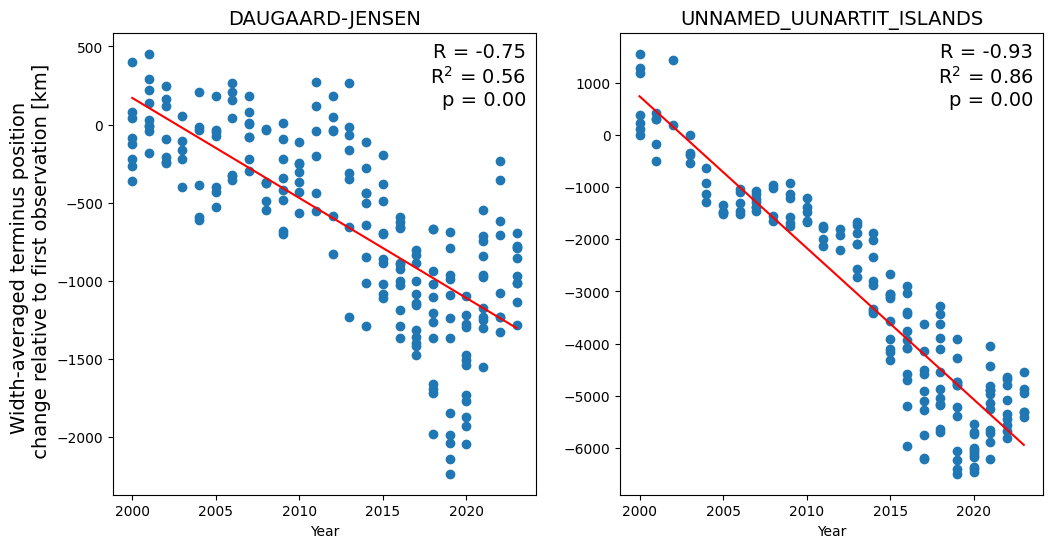

In [2]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load terminus change data
terminus_ds = xr.open_dataset("../data/terminus/terminus_2000_2023.nc")

for i, (glacier, ds) in enumerate(terminus_ds.groupby("glacier", squeeze=False)):
    # Resample terminus change to annual means and extract years
    terminus_change = ds.area_width_averaged_change.squeeze().resample(time="1MS").mean()
    years = terminus_change.time.dt.year

    mask = terminus_change.notnull() & years.notnull()
    terminus_change = terminus_change.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress terminus change against year
    res = scipy.stats.linregress(years, terminus_change)

    # Plot data and trendline
    axs[i].plot(years, terminus_change, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R = {res.rvalue:.2f}\n R$^{{2}}$ = {res.rvalue**2:.2f}\np = {res.pvalue:.2f}",
            loc="upper right",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)
    axs[i].set_xlabel("Year")

axs[0].set_ylabel("Width-averaged terminus position \n change relative to first observation [km]", size=14)

plt.show()